# IMPORTS

In [ ]:
!pip install tensorflow==2.1.0

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Concatenate, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional,Input, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re
import ast
from sklearn.datasets import make_classification
from collections import Counter
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing

In [ ]:
#Loading the cases
path_to_json = '/content/drive/MyDrive/howest_dataset/'
dataset= pd.DataFrame()
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for json_file in json_files:
    json_file=path_to_json+json_file
    with open(json_file) as train_file:
        dict_train = json.load(train_file)
    file_df=pd.DataFrame.from_dict(pd.json_normalize(dict_train), orient='columns')
    dataset=dataset.append(file_df,ignore_index = True)

In [ ]:
#Drop unnessecary columns
dataset.drop(['client_reference','mail_subject','party_id','party_type','unit_id','organization','from_mail','comments'], axis=1, inplace=True) 

In [1]:
#Text preprocessing
def text_processing(content):
    text_no_html = BeautifulSoup(str(content),"html.parser" ).get_text()
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
    text_lower = text_alpha_chars.lower()
    stops = set(stopwords.words('dutch') +stopwords.words('french')+stopwords.words('english'))
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '

    text_no_short_words=''
    for w in text_no_stop_words.split(): 
        if len(w) >=2:
            text_no_short_words = text_no_short_words + w + ' '

    text_no_eng_words=''
    for w in text_no_short_words.split():
        if w not in words.words():
          if w not in wordnet.words():
            text_no_eng_words = text_no_eng_words + w + ' '

    print(text_no_eng_words)

    return text_no_eng_words
#Get filenames from attachments
def get_fileNames(attachment):
    fileNames=[]
    for obj in attachment:
        fileNames.append(obj['filename'].replace('.pdf', ''))
        fileNamesStr = ' '.join(fileNames)
    return fileNamesStr
#Get content from attachments
def get_content(attachment):
    contents=[]
    for obj in attachment:
        contents.append(obj['content'])
        contentsStr = ' '.join(contents)
        contentsStr=text_processing(contentsStr)
    return contentsStr
    

In [ ]:
dataset['mail_content']=dataset['mail_content'].apply(text_processing)
dataset['attachments_filename']=dataset['attachments'].apply(get_fileNames)
dataset['attachments_content']=dataset['attachments'].apply(get_content)
dataset.drop('attachments', axis=1, inplace=True)

In [ ]:
#Only use top 6 of sub_case_type and damage_type
top_amount = 6
list_top_label_sub = list(dataset["labels.sub_case_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_sub)
dataset = dataset[dataset["labels.sub_case_type"].isin(list_top_label_sub)]
list_top_label_damage = list(dataset["labels.damage_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_damage)
dataset = dataset[dataset["labels.damage_type"].isin(list_top_label_damage)]

In [4]:
#Create thumbling window for the attachment_content text. Limit of 500 words on LSTM
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index()
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [ ]:
dataset

In [ ]:
#drop level column ex: level_7
dataset=dataset.drop(['level_NUMBER'],axis=1)

In [ ]:
#Split targets and features
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type','language'], axis=1)

In [ ]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

In [ ]:
#Safe original test set(for evaluation)
X_test_original=X_test

# Analysis


In [ ]:
#Checking unbalancedness
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=dataset,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=dataset,ax=ax[1])
sns.countplot(x='labels.damage_type',data=dataset,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=dataset,ax=ax[3])

In [ ]:
#Correlation between targets
y_copy=y
y_cat1=pd.Categorical(y_copy['labels.assignment_type'])
y_copy['labels.assignment_type']=y_cat1.codes

y_cat2=pd.Categorical(y_copy['labels.case_type'])
y_copy['labels.case_type']=y_cat2.codes

y_cat3=pd.Categorical(y_copy['labels.sub_case_type'])
y_copy['labels.sub_case_type']=y_cat3.codes

y_cat4=pd.Categorical(y_copy['labels.damage_type'])
y_copy['labels.damage_type']=y_cat4.codes

f, ax = plt.subplots(figsize=(10, 8))
corr = y_copy.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

# Tokenizer

In [ ]:
#Max number of words and embedding dimension
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

In [ ]:
#mail_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

In [ ]:
#attachments_filename Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

In [ ]:
#attachments_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

In [ ]:
#Categorical
#assignment_type
train_assignment_cats=pd.Categorical(y_train['labels.assignment_type'])
test_assignment_cats=pd.Categorical(y_test['labels.assignment_type'])
y1_train=train_assignment_cats.codes
y1_test=test_assignment_cats.codes

#case_type
train_case_cats=pd.Categorical(y_train['labels.case_type'])
test_case_cats=pd.Categorical(y_test['labels.case_type'])
y2_train=train_case_cats.codes
y2_test=test_case_cats.codes

#sub_case_type
train_sub_case_cats=pd.Categorical(y_train['labels.sub_case_type'])
test_sub_case_cats=pd.Categorical(y_test['labels.sub_case_type'])
y3_train=train_sub_case_cats.codes
y3_test=test_sub_case_cats.codes

#damage_type
train_damage_cats=pd.Categorical(y_train['labels.damage_type'])
test_damage_cats=pd.Categorical(y_test['labels.damage_type'])
y4_train=train_damage_cats.codes
y4_test=test_damage_cats.codes

print('Shape of label tensor Y1 Train:', y1_train.shape)
print('Shape of label tensor Y1 Test:', y1_test.shape)
print('Shape of label tensor Y2 Train:', y2_train.shape)
print('Shape of label tensor Y2 Test:', y2_test.shape)
print('Shape of label tensor Y3 Train:', y3_train.shape)
print('Shape of label tensor Y3 Test:', y3_test.shape)
print('Shape of label tensor Y4 Train:', y4_train.shape)
print('Shape of label tensor Y4 Test:', y4_test.shape)

# Model

In [ ]:
#Determine class weights
class_weights_assignment = dict(zip(np.unique(y1_train), class_weight.compute_class_weight('balanced', np.unique(y1_train), 
                np.ravel(y1_train)))) 

class_weights_case = dict(zip(np.unique(y2_train), class_weight.compute_class_weight('balanced', np.unique(y2_train), 
                np.ravel(y2_train)))) 

class_weights_sub_case = dict(zip(np.unique(y3_train), class_weight.compute_class_weight('balanced', np.unique(y3_train), 
                np.ravel(y3_train)))) 

class_weights_damage = dict(zip(np.unique(y4_train), class_weight.compute_class_weight('balanced', np.unique(y4_train), 
                np.ravel(y4_train)))) 

In [ ]:
#Optimizer
opt = tf.keras.optimizers.Adam(lr=0.0001)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)
#checkpoint
checkpoint_path='{PATH_TO_MODEL_CHECKPOINT}'
mc=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)
#Model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))
#Embedding
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)
#LSTM layers
s_mc=SpatialDropout1D(0.5)(embeding_mc)
o_mc=LSTM(64, dropout=0.5)(s_mc)
s_af=SpatialDropout1D(0.5)(embeding_af)
o_af=LSTM(64, dropout=0.5)(s_af)
s_ac=SpatialDropout1D(0.5)(embeding_ac)
o_ac=LSTM(64, dropout=0.5)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])
#Dense layers
r=Dense(64, activation='relu')(concat_layer)
r1=Dense(16, activation='relu')(r)
#Output layers
o1=Dense(2, activation='softmax',name='assignment_type')(r)
o2=Dense(3, activation='softmax',name='case_type')(r)
o3=Dense(6, activation='softmax',name='sub_case_type')(r)
o4=Dense(6, activation='softmax',name='damage_type')(r)

epochs = 400
batch_size = 254
model = Model(inputs=[input_mc,input_af,input_ac], outputs=[o1, o2, o3, o4])
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit([X_train_mc,X_train_af,X_train_ac],[y1_train,y2_train,y3_train,y4_train],class_weight={ 'assignment_type': class_weights_assignment , 'case_type': {0: 0.8066606840163526, 1: 0.5681977805871611, 2: 2.6666666666665},'sub_case_type':{0: 3.28982755893054896,1: 3.5715177039463423,2: 1.188859878154917,3: 1.9525350593311757,4: 3.196868008948545,5: 2.980392156862745}, 'damage_type':{0: 2.,1: 5.,2: 4.,3: 1.,4: 2.,
 5: 0.5}},epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[es,mc])

# Evaluation

In [ ]:
score = model.evaluate(x=[X_test_mc,X_test_af,X_test_ac], y=[y1_test, y2_test, y3_test, y4_test], verbose=1)
print("Loss:", score[0])
print("Test Accuracy:", score[1])

1833/1833 [==============================] - 6s 3ms/sample - loss: 1.1931 - assignment_type_loss: 0.1593 - case_type_loss: 0.2154 - sub_case_type_loss: 0.3963 - damage_type_loss: 0.4141 - assignment_type_accuracy: 0.9400 - case_type_accuracy: 0.9471 - sub_case_type_accuracy: 0.9111 - damage_type_accuracy: 0.8718
Loss: 1.1930749473582183
Test Accuracy: 0.1593248


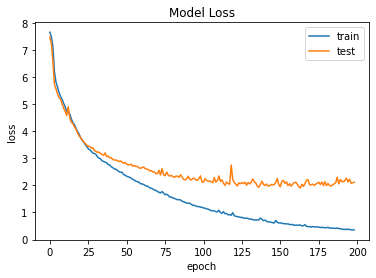

In [ ]:
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

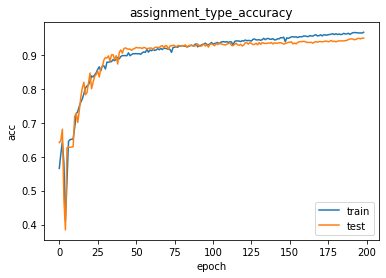

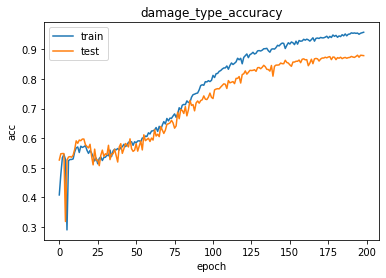

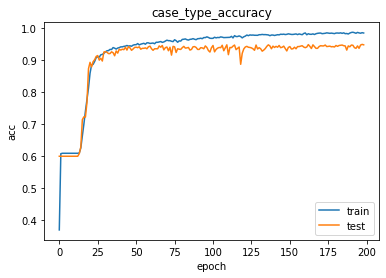

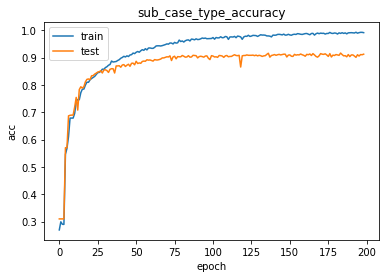

In [ ]:
plt.title('assignment_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_accuracy'], label='train')
plt.plot(history.history['val_assignment_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_accuracy'], label='train')
plt.plot(history.history['val_damage_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_accuracy'], label='train')
plt.plot(history.history['val_case_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_accuracy'], label='train')
plt.plot(history.history['val_sub_case_type_accuracy'], label='test')
plt.legend()
plt.show();

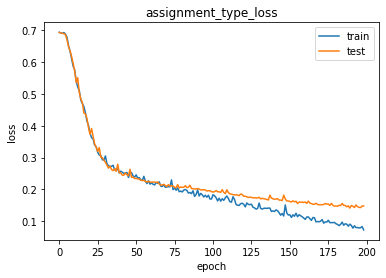

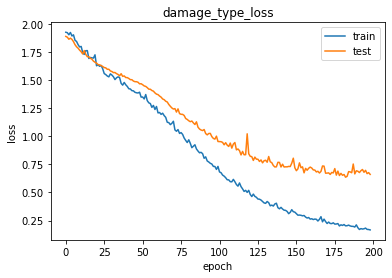

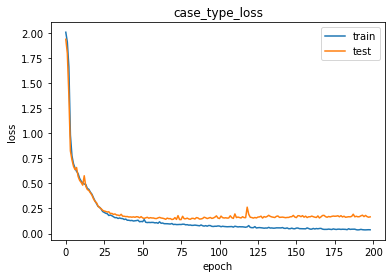

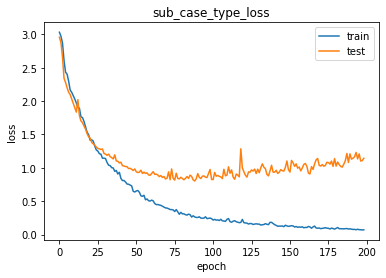

In [ ]:
plt.title('assignment_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_loss'], label='train')
plt.plot(history.history['val_assignment_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_loss'], label='train')
plt.plot(history.history['val_damage_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('case_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['case_type_loss'], label='train')
plt.plot(history.history['val_case_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_loss'], label='train')
plt.plot(history.history['val_sub_case_type_loss'], label='test')
plt.legend()
plt.show();

# Test precitions

In [ ]:
# Testing with the test set
# Loading the the best performing model
model.load_weights('{PATH_TO_MODEL_CHECKPOINT}')
y1_pred,y2_pred,y3_pred,y4_pred = model.predict([X_test_mc,X_test_af,X_test_ac])

In [ ]:
#Predictions to dataframe
predictions_assign=pd.DataFrame(columns=['pred.assignment'],data=test_assignment_cats.categories[np.argmax(y1_pred,axis=1)])
predictions_case=pd.DataFrame(columns=['pred.case'],data=test_case_cats.categories[np.argmax(y2_pred,axis=1)])
predictions_sub_case=pd.DataFrame(columns=['pred.sub_case'],data=test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)])
predictions_damage=pd.DataFrame(columns=['pred.damage'],data=test_damage_cats.categories[np.argmax(y4_pred,axis=1)])
result = pd.concat([X_test_original,predictions_case,predictions_sub_case,predictions_damage,predictions_assign,y_test], axis=1, join="inner")

In [ ]:
#Show results
result

,mail_content,attachments_filename,attachments_content,pred.case,pred.sub_case,pred.damage,pred.assignment,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
514,sans mevrouw contacteren verzekeraar bijlage ...,1381789_01-20-2021_320087058 OM Adv Aangifte P...,kosten euro twintig cent toepassing artikel re...,Property,_PrivateClaim,Other_DamageType,Unilateral,Liability,Operations,Other_DamageType,Bilateral
317,sans contactons qualit trouverez annexe docum...,Aangifte PR Axa IGBS Polis Axa Foto's afw bes...,non adresse kai erar cis compagnie i' pv timen...,Liability,Operations,Other_DamageType,Bilateral,Property,_PrivateClaim,Other_DamageType,Bilateral
1067,sans contactons qualit trouverez annexe docum...,VIVIUM GL C302004698 C36 Inspection - DM 2021-...,cas dommage materiel si rue royale expert num ...,Liability,Operations,Other_DamageType,Bilateral,Property,Other,Other_DamageType,Bilateral
1533,sans mevrouw contacteren verzekeraar bijlage ...,polis VIVIUM GL C302101520 C36 Inspectie - MS ...,sent fri subject viv burgerlijke aansprakelijk...,Property,Fire,WaterDamage,Bilateral,Liability,Operations,Other_DamageType,Bilateral
704,sans mevrouw contacteren verzekeraar bijlage ...,polis versie vz v. pr bestek+ geg. tp aangifte...,sent thu jan subject sent subject voir documen...,Liability,Other,Other_DamageType,Bilateral,Liability,Operations,Other_DamageType,Bilateral
...,...,...,...,...,...,...,...,...,...,...,...
916,sans mevrouw contacteren verzekeraar bijlage ...,1444846_02-01-2021_320062078 POLIS VIVIUM GL C...,sent subject nieuwe aangifte onze referte ba s...,Liability,Operations,Other_DamageType,Bilateral,Liability,Operations,Other_DamageType,Bilateral
1597,annexe transmettons document concernant missi...,ZCN200361118- AKIN- ZSN192014361 lettre ciet +...,jonathan date september subject dossier aucun ...,Property,Fire,WaterDamage,Unilateral,Property,Fire,WaterDamage,Unilateral
1098,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT foto foto foto aangifte+ba...,nv koning bic btw verzekeringsmaatschappij toe...,Property,Fire,WaterDamage,Unilateral,Property,Fire,WaterDamage,Bilateral
461,bijlage wij document betrekking opdracht toev...,Mail verz verz heeft dakwerken uitgevoerd - ...,adres verzekerde ligging risico toepassing lig...,Liability,Other,Other_DamageType,Bilateral,Liability,Operations,WaterDamage,Bilateral


# Test Classification Reports

In [ ]:
cf = confusion_matrix(test_assignment_cats,test_assignment_cats.categories[np.argmax(y1_pred,axis=1)])
cr= classification_report(test_assignment_cats,test_assignment_cats.categories[np.argmax(y1_pred,axis=1)],target_names=pd.Categorical(test_assignment_cats.categories))
print("assignment_type")
print(cr)
print(cf)

assignment_type
              precision    recall  f1-score   support

   Bilateral       0.97      0.93      0.95      1196
  Unilateral       0.88      0.95      0.92       637

    accuracy                           0.94      1833
   macro avg       0.93      0.94      0.93      1833
weighted avg       0.94      0.94      0.94      1833

[[1117   79]
 [  31  606]]


In [ ]:
cf = confusion_matrix(test_case_cats,test_case_cats.categories[np.argmax(y2_pred,axis=1)])
cr= classification_report(test_case_cats,test_case_cats.categories[np.argmax(y2_pred,axis=1)],target_names=pd.Categorical(test_case_cats.categories))
print("case_type")
print(cr)
print(cf)

case_type
              precision    recall  f1-score   support

  Automotive       0.00      0.00      0.00         1
   Liability       0.98      0.88      0.93       683
    Property       0.93      0.99      0.96      1149

    accuracy                           0.95      1833
   macro avg       0.64      0.62      0.63      1833
weighted avg       0.95      0.95      0.95      1833

[[   0    0    1]
 [   0  602   81]
 [   0   15 1134]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf = confusion_matrix(test_sub_case_cats,test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)])
cr= classification_report(test_sub_case_cats,test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)],target_names=pd.Categorical(test_sub_case_cats.categories))
print("sub_case_type")
print(cr)
print(cf)

sub_case_type
               precision    recall  f1-score   support

         Auto       0.70      0.48      0.57        29
     Familial       0.87      0.81      0.84        89
         Fire       0.94      0.96      0.95      1071
   Operations       0.92      0.90      0.91       522
        Other       0.51      0.62      0.56        40
_PrivateClaim       0.84      0.74      0.79        82

     accuracy                           0.91      1833
    macro avg       0.79      0.75      0.77      1833
 weighted avg       0.91      0.91      0.91      1833

[[  14    0   10    2    2    1]
 [   0   72    6    8    3    0]
 [   4    0 1029   26    7    5]
 [   0   11   38  469    4    0]
 [   1    0    4    4   25    6]
 [   1    0   10    2    8   61]]


In [ ]:
#Categorical
cf = confusion_matrix(test_damage_cats,test_damage_cats.categories[np.argmax(y4_pred,axis=1)])
cr= classification_report(test_damage_cats,test_damage_cats.categories[np.argmax(y4_pred,axis=1)],target_names=pd.Categorical(test_damage_cats.categories))
print("damage_type")
print(cr)
print(cf)

damage_type
                      precision    recall  f1-score   support

           Collision       0.84      0.78      0.81       161
Fire_Smoke_Explosion       0.66      0.72      0.68        53
       GlassBreakage       0.67      0.79      0.72        61
    Other_DamageType       0.83      0.88      0.86       427
               Storm       0.74      0.81      0.77       122
         WaterDamage       0.94      0.90      0.92      1009

            accuracy                           0.87      1833
           macro avg       0.78      0.81      0.79      1833
        weighted avg       0.88      0.87      0.87      1833

[[125   0   3  20  12   1]
 [  2  38   3   2   2   6]
 [  0   0  48   7   1   5]
 [ 11   2   4 377   1  32]
 [  2   5   2   2  99  12]
 [  8  13  12  46  19 911]]
